In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# install PySpark 
#http://spark.apache.org/docs/latest/api/python/index.html

!pip install pyspark==3.2

In [ ]:
# Import libraries and other functions
from io import StringIO
from collections import namedtuple
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *

from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, datediff, lit
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation


import csv
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

# start spark sessnon and configureation
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
%matplotlib inline
import matplotlib.pyplot as plt
from pyspark.sql.functions import count
from pyspark.sql.functions import desc

In [ ]:

spark = SparkSession.builder.master("local[2]").appName("dat").getOrCreate()
sc = spark.sparkContext
#create an instance of SQLContext
sqlContext = SQLContext(spark)

In [ ]:
#create a dataFrame directly from City of London Street Crime csv file 
#https://data.police.uk/data/

County_Crime = spark.read.option("header", "true").option("delimiter", ",")\
.option("inferSchema", "true").\
csv("/kaggle/input/crime-dataset-march-20-23/*street.csv")

In [ ]:
County_Crime.printSchema()

In [ ]:
County_Crime = County_Crime.withColumnRenamed('Crime ID', 'Crime_ID')
County_Crime = County_Crime.withColumnRenamed('Reported by', 'Reported_by')
County_Crime = County_Crime.withColumnRenamed('Falls within', 'Falls_within')
County_Crime = County_Crime.withColumnRenamed('LSOA code', 'LSOA_code')
County_Crime = County_Crime.withColumnRenamed('LSOA name', 'LSOA_name')
County_Crime = County_Crime.withColumnRenamed('Crime type', 'Crime_type')
County_Crime = County_Crime.withColumnRenamed('Last outcome category', 'Last_outcome_category')

In [ ]:
County_Crime.printSchema()

In [ ]:
County_Crime.take(2)

In [ ]:
County_Crime.show()

In [ ]:
print('The total records in the County_Crime is ' + str(County_Crime.count()))


cleaning

missing

In [ ]:
missing_count=County_Crime.select([sum(col(c).isNull().cast("int")).alias(c) for c in County_Crime.columns ])

In [ ]:
missing_count.toPandas()

In [1]:
filtered_df = County_Crime.filter((County_Crime["Crime_ID"].isNull()) & (County_Crime["Last_outcome_category"].isNull()))
filtered_df.show()


NameError: name 'County_Crime' is not defined

In [ ]:
distinct_crime_types = filtered_df.select("Crime_type").distinct().collect()
#distinct_crime_types.show()
crime_types = [row['Crime_type'] for row in distinct_crime_types]
print("Crime types with null values are: " + ", ".join(crime_types))



In [ ]:
distinct_crime_types = filtered_df.select("Crime_type").distinct()

# Convert the DataFrame to a list of crime types
crime_types_list = [row["Crime_type"] for row in distinct_crime_types.collect()]

# Print the crime types
for crime_type in crime_types_list:
    print(crime_type)


In [ ]:
County_Crime=County_Crime.drop("Context","Crime_ID") ## since hexadecimal values values and context have all fields blank

In [ ]:
# Filter records with missing LSOA name
missing_lsoa_records = County_Crime.filter(isnull(County_Crime['LSOA_name']))

# Select the relevant columns for display
display_records = missing_lsoa_records.select("LSOA_name","LSOA_code","Location")

# Show the records
display_records.show(truncate=False)


In [ ]:
County_Crime.printSchema()

handling missing

after analysis we understand, anti-social behaviour has crie tID and last outcome missing. retaining last outcome

Crime data analysis :

what crime categories does the police data use ?


In [ ]:
#spark.sql("DROP TABLE IF EXISTS tbl_County_Crime")

#register temp tables 
County_Crime.registerTempTable("tbl_County_Crime")

In [ ]:
crime_category = spark.sql("SELECT DISTINCT `Crime_type` AS Crime_Type FROM tbl_County_Crime")
crime_category.show()



using pandas for better visualization

In [ ]:
crime_category.show()
crime_category.toPandas()


check crime category same for each city

In [ ]:
# Filter the data based on the city
cumbria_crime_data = County_Crime.filter(County_Crime["Reported_by"] == 'Cumbria Constabulary')
leicestershire_crime_data = County_Crime.filter(County_Crime["Reported_by"] == 'Leicestershire Police')
nottinghamshire_crime_data = County_Crime.filter(County_Crime["Reported_by"] == 'Nottinghamshire Police')

# Get the unique crime types for each city
unique_crime_types_cumbria = cumbria_crime_data.select("Crime_type").distinct()
unique_crime_types_leicestershire = leicestershire_crime_data.select("Crime_type").distinct()
unique_crime_types_nottinghamshire = nottinghamshire_crime_data.select("Crime_type").distinct()

# Convert the unique crime types to lists
crime_types_cumbria = [row["Crime_type"] for row in unique_crime_types_cumbria.collect()]
crime_types_leicestershire = [row["Crime_type"] for row in unique_crime_types_leicestershire.collect()]
crime_types_nottinghamshire = [row["Crime_type"] for row in unique_crime_types_nottinghamshire.collect()]

if set(crime_types_cumbria) == set(crime_types_leicestershire) == set(crime_types_nottinghamshire):
    print("same")
else:
    print("different")
   

Top crimes across cties 

In [ ]:
from pyspark.sql.functions import desc, lit

# Define the list of target cities
target_cities = ["Cumbria", "Leicestershire", "Nottinghamshire"]

# Create an empty DataFrame to store the results
result_df = spark.createDataFrame([], schema="Crime_Type STRING, count INT, County STRING")

# Create an empty DataFrame to store the count separately
count_df = spark.createDataFrame([], schema="City STRING, count INT")

# Iterate over the target cities
for target_city in target_cities:
    # Get the crime data for the target city
    city_data = globals()[target_city.lower() + "_crime_data"]

    # Group by crime type and count the number of occurrences
    crime_counts = city_data.groupBy("Crime_type").count()

    # Order the crime counts in descending order
    sorted_crime_counts = crime_counts.orderBy(desc("count"))

    # Get the top 10 crimes for the target city
    top_10_crimes = sorted_crime_counts.limit(3)

    # Add the city name to the result DataFrame
    top_10_crimes_with_city = top_10_crimes.withColumn("County", lit(target_city))

    # Append the results to the overall result DataFrame
    result_df = result_df.union(top_10_crimes_with_city)

    # Select only the count column and add the city name to the count DataFrame
    count_only = top_10_crimes.select("count").withColumn("City", lit(target_city))

    # Append the count to the separate count DataFrame
    count_df = count_df.union(count_only)

# Show the top 10 crimes across each city
result_df.show()
# Convert the result DataFrame to a Pandas DataFrame
result_pd = result_df.toPandas()
result_pd

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define a color palette for each city
color_palette = ['red', 'blue', 'green']

# Iterate over the target cities
for i, target_city in enumerate(target_cities):
    # Filter the data for the current city
    city_data = result_pd[result_pd['County'] == target_city]

    # Set the figure size
    plt.figure(figsize=(10, 6))

    # Get the crime types and counts for the current city
    crime_types = city_data['Crime_Type']
    counts = city_data['count']

    # Set the positions for the bars on the x-axis
    x_pos = np.arange(len(crime_types))

    # Plot the stacked bars with different colors for each city
    plt.bar(x_pos, counts, label=target_city, color=color_palette[i])

    # Set the x-axis tick positions and labels
    plt.xticks(x_pos, crime_types, rotation=45)

    # Set the title and labels
    plt.title(f'Top 3 Crimes in {target_city}')
    plt.xlabel('Crime Type')
    plt.ylabel('Count')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the result_df DataFrame to a Pandas DataFrame
result_pandas = result_df.toPandas()

# Pivot the Pandas DataFrame to create a matrix for the heatmap
heatmap_matrix = result_pandas.pivot("County", "Crime_Type", "count")

# Plot the heatmap using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_matrix, annot=True, cmap="YlOrRd", fmt="d")
plt.title("Crime Types Across Cities Heatmap")
plt.xlabel("Crime Type")
plt.ylabel("City")
plt.show()


-----------------------------------------------------

# Within cities 

Which city has highest crime rate?Percentage of Crimes rates across each Area of juridiction-

In [ ]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Group by city and count the number of crimes
crime_counts = County_Crime.groupBy("Falls_within").count()

# Convert the crime count DataFrame to a Pandas DataFrame
count_pd = crime_counts.toPandas()

# Extract the city names and count values
cities = count_pd["Falls_within"]
counts = count_pd["count"]

# Plot the pie chart
plt.pie(counts, autopct='%1.1f%%')
plt.title("Crime Distribution Across Cities")
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle

# Add a legend with descriptions
plt.legend(title="City Descriptions", labels=cities, loc="center left", bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()


In [ ]:

# Run the SQL query and retrieve the data as a DataFrame
filtereddata = spark.sql("select Month, count(Crime_Type) as CrimeNumbers FROM tbl_County_Crime where Crime_Type='Violence and sexual offences' and Month >= '2020-03' and Month <= '2023-03' group by Month order by Month")


which crime has thehighest rate


In [ ]:

# Execute the SQL query to retrieve the count of each crime type
crime_category = spark.sql("SELECT Crime_Type, COUNT(*) AS Count FROM tbl_County_Crime GROUP BY Crime_Type")

# Convert the result to a Pandas DataFrame for plotting
crime_category_pandas = crime_category.toPandas()

# Sort the DataFrame by count in descending order
crime_category_pandas = crime_category_pandas.sort_values(by='Count', ascending=False)

# Create a colormap with the number of colors equal to the number of bars
colormap = plt.cm.get_cmap('Set3', len(crime_category_pandas))

# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(crime_category_pandas['Crime_Type'], crime_category_pandas['Count'], color=colormap(np.arange(len(crime_category_pandas))))
plt.xlabel('Count')
plt.ylabel('Crime Types')
plt.title('Distribution of Crime Types')

# Invert the y-axis to display the bars from top to bottom
plt.gca().invert_yaxis()

# Display the plot
plt.show()



Have the same categories been used consistently?¶

In [ ]:
crime_mon_category =  spark.sql("select distinct Crime_Type, EXTRACT(YEAR FROM Month) as Year from tbl_County_Crime group by Crime_Type, Year order by Year")
crime_mon_category.show(200)

In [ ]:
pd.set_option('display.max_rows', 500)

# Convert the result to a Pandas DataFrame for plotting
crime_mon_category.toPandas()

display.max_rows increases the number of rows displayed while showing toPandas() output.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# Execute the SQL query to retrieve the count of each crime type for each year
crime_mon_category = spark.sql("SELECT Crime_Type, EXTRACT(YEAR FROM Month) AS Year, COUNT(*) AS Count FROM tbl_County_Crime GROUP BY Crime_Type, Year ORDER BY Year")

# Convert the result to a Pandas DataFrame for plotting
crime_mon_category_pandas = crime_mon_category.toPandas()

# Pivot the DataFrame to have years as columns and crime types as index
stacked_df = crime_mon_category_pandas.pivot(index='Crime_Type', columns='Year', values='Count').fillna(0)

# Plot the stacked bar chart
stacked_df.plot.bar(stacked=True, figsize=(10, 6))

# Set the axis labels and title
plt.xlabel('Crime Type')
plt.ylabel('Count')
plt.title('Stacked Bar Chart of Crime Types by Year')

# Display the plot
plt.show()


Question 3 : Are levels of violent crime constant, increasing, or decreasing?


In [ ]:

# Run the SQL query and retrieve the data as a DataFrame
filtereddata = spark.sql("select Month, count(Crime_Type) as CrimeNumbers FROM tbl_County_Crime where Crime_Type='Violence and sexual offences' and Month >= '2020-03' and Month <= '2023-03' group by Month order by Month")
filpanda = filtereddata.toPandas()
filpanda

Is ther a correlation with month and crime?


In [ ]:

# Convert the "Month" column to a date data type
filtereddata = filtereddata.withColumn("Month", to_date(filtereddata["Month"], "yyyy-MM"))

# Calculate the number of days since the minimum date in the "Month" column
min_date = filtereddata.selectExpr("min(Month)").first()[0]
min_date_str = min_date.strftime("%Y-%m")  # Convert to string
filtereddata = filtereddata.withColumn("Month", datediff(filtereddata["Month"], lit(min_date_str)))

# Select numerical columns of interest
numerical_cols = ['Month', 'CrimeNumbers']
selected_data = filtereddata.select(numerical_cols)

# Assemble the features into a vector column
assembler = VectorAssembler(inputCols=numerical_cols, outputCol='features')
assembled_data = assembler.transform(selected_data).select('features')

# Compute the correlation matrix
correlation_matrix = Correlation.corr(assembled_data, 'features')

# Extract the correlation matrix as a NumPy array
corr_array = correlation_matrix.collect()[0]['pearson(features)'].values

# Convert the correlation matrix to a square matrix
corr_matrix = np.reshape(corr_array, (2, 2))

# Create a heatmap of the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', xticklabels=numerical_cols, yticklabels=numerical_cols)

# Display the plot
plt.show()


From the graph we can see that correlation coefficient we can see there appears to be a moderate positive linear relationship between the month since the minimum date and the count of violence and sexual offences. This suggests that as the month progressess there is a tendency for the count of crimes to increase as well.

However, correlation does not imply causation. Just because two variables are correlated does not mean that one variable directly causes the other to change. Correlation only measures the strength and direction of the relationship between variables. There may be other underlying factors or variables influencing  relationship.

Inorder to draw meaningful conclusions and understand the causal factors behind the relationship, further analysis and considerations are required. This may involve examining additional variables, conducting statistical tests, considering external factors or confounding variables, and applying domain knowledge or expert insights.

Pandas ususally have index created by default but for visualizing data using time series, we need index based on datetime64 data type. Hence we create a new pandas data frame with index set as month using set_index() function.

In [ ]:
#to print
filpanda.Month = filpanda.Month.astype('datetime64[ns]')
filpanda2 = filpanda.set_index(pd.to_datetime(filpanda.Month))

Checking the index of new panda using .index() function

In [ ]:
filpanda2.index

.plot() in pandas can be used to create graph with month on x axis and CrimeNumbers on y axis. To visualize the graph on the screen, we may use Pyplot, a submodule of the Matplotlib package. Various other attributes like marker, linestyle, linewidth for .plot() function can be used to better visualize the graph.

In [ ]:
plt.figsize=(20, 10)

filpanda2.plot(y='CrimeNumbers', x='Month',marker='.', linestyle='-', linewidth=1,\
         subplots=False,
              label='Monthly Crime Numbers',
              title='Crime Numbers Vs Month')
plt.ylabel('Crime Numbers')
plt.xlabel('Year')

Is there is correlation betwenn month and crime count?


In [ ]:
#filpanda = filtereddata.toPandas()
#filpanda

.show() launches one or more interactive windows that display our figure by searching for all currently active figure objects

In [ ]:
%%time
plt.show()

Decomposing a time series entails spliting it as a collection of level, trend, seasonality, and noise components.
The average value in the series is called the level.
The increasing or decreasing value in the series is referred to as the trend.
Seasonality is the series' recurring short-term cycle.
The random variations in the series is referred to as noise.

In an addictive model, y(t) = Level + Trend + Seasonality + Noise

We use sm.tsa.seasonal_decompose() function to decompose our time series data into trend, seasonal variations and noise. Output graphs are as shown below.

Are there any seasonal or temporal patterns in crime rates for each county? Analyze the crime rates over time (monthly, quarterly, or yearly) to identify any recurring patterns or trends.

In [ ]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(filpanda2['CrimeNumbers'], model='additive',extrapolate_trend='freq')
fig = decomposition.plot()
fig.set_size_inches(14,7)
plt.show()

From the graphs plotted, it is very clear that violent crimes have been on the rise from 2021. The trend clearly shows an increase in the slope. However the numbers have been almost constant after 2019, steep slope in trend has been flattened. We can also see some seasonal variations in violent crime numbers where the crime numbers go up drastically during summer and subsequently reduce during winter.



Question 4 : The Leicestershire region was removed from local lockdown in July 2020. Verify your findings (if any) with respect to that region only

In [ ]:
spark.sql("DROP TABLE IF EXISTS tbl_Leicestershire")

In [ ]:
#County_Crime.registerTempTable("tbl_Leicestershire")
County_Crime.registerTempTable("tbl_Leicestershire")

In [ ]:
crime_leicester = spark.sql("SELECT Crime_type, Month, `LSOA_name` FROM tbl_Leicestershire WHERE `LSOA_name` LIKE ('%Leicester%') AND Crime_type IN ('Violent crime', 'Violence and sexual offences') AND Month >= '2020-01' ORDER BY Month, `LSOA_name`")

In [ ]:
County_Crime.createTempView("tbl_leicester_month")
#We also group the count of violent crimes by month

In [ ]:
crime_leicester_month = spark.sql("SELECT count(Crime_Type) as CrimeNumbers, Month FROM tbl_leicester_month group by Month order by Month")

In [ ]:
#Output of the filtered data is coverted to pandas.
crime_leicester_month_panda = crime_leicester_month.toPandas()
crime_leicester_month_panda

In [ ]:
# Plot the trend in crime numbers for Leicester region
crime_leicester_month_panda.plot.bar(x='Month', y='CrimeNumbers', figsize=(10, 6))

# Set the axis labels and title
plt.xlabel('Month')
plt.ylabel('Crime Numbers')
plt.title('Trend in Crime Numbers for Leicester Region')

# Display the plot
plt.show()

Answer :
A local lockdown was imposed in Leicester region in July 2020. By analysing the data in a graphical approcah, we can see that there is a significant increase in number of violent crimes for July and August 2020. This could be attributed to the local locakdown imposed on the region

Crime across city - highest crime city?


In [ ]:
County_Crime.createTempView("tbl_allcounty_crimes")

In [ ]:
from pyspark.sql.functions import col, sum
import matplotlib.pyplot as plt

# Calculate total number of crimes by county
crimeRateByCounty = spark.sql("SELECT `Falls_within` AS County, COUNT(*) AS CrimeCount FROM tbl_allcounty_crimes GROUP BY `Falls_within`")

# Calculate total number of crimes across all counties
totalCrimes = crimeRateByCounty.select(sum("CrimeCount")).collect()[0][0]

# Calculate the crime rate for each county
crimeRateByCounty = crimeRateByCounty.withColumn("CrimeRate", crimeRateByCounty["CrimeCount"] / totalCrimes)

# Convert the result DataFrame to a Pandas DataFrame
count_pd = crimeRateByCounty.toPandas()

# Extract the county names and crime count values
counties = count_pd["County"]
crime_counts = count_pd["CrimeCount"]

# Plot the bar chart
plt.bar(counties, crime_counts)
plt.title("Crime Distribution Across Counties")
plt.xlabel("County")
plt.ylabel("Crime Count")
plt.xticks(rotation=45)

# Show the plot
plt.show()


trail

within - total counts each type of  crime recorded?

In [ ]:
County_Crime.createTempView("tbl_crime_types")

In [ ]:
crime_leicester_month = spark.sql("SELECT count(Crime_Type) as CrimeNumbers, Month FROM tbl_crime_types group by Month order by Month")

In [ ]:
from pyspark.sql.functions import col, sum

# Group by county and crime type and count the number of occurrences
crime_counts = County_Crime.groupBy("Falls_within", "Crime_type").agg(sum("CrimeNumbers").alias("Total_Count"))

# Show the total count of each type of crime recorded in each county
crime_counts.show()


Within -Are there any specific areas or neighborhoods within each county with higher crime rates? Analyze the crime rates at a more granular level, such as by neighborhood or specific geographical regions, to identify areas that require targeted intervention or resources.

In [ ]:
County_Crime.createTempView("tbl_neighbourhood_crimes")

In [ ]:
# Read crime data into a Spark DataFrame
crime_data = spark.sql("SELECT * FROM tbl_neighbourhood_crimes")

# Group the data by county and location, and calculate the crime rate
crime_rates = crime_data.groupby("Crime_Type", "Location").count()

# Show the crime rates by neighborhood within each county
crime_rates.show()



In [ ]:
import matplotlib.pyplot as plt

# Convert the crime rates DataFrame to Pandas for plotting
crime_rates_pandas = crime_rates.toPandas()

# Plot the crime rates by neighborhood within each county
plt.figure(figsize=(10, 6))
crime_rates_pandas.plot.bar(x='Location', y='count', rot=45, width=0.8)

# Set the axis labels and title
plt.xlabel('Neighborhood')
plt.ylabel('Crime Rate')
plt.title('Crime Rates by Neighborhood within Each County')

# Display the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Sort the crime rates DataFrame by count in descending order
sorted_crime_rates = crime_rates.orderBy("count", ascending=False)

# Select the top 10 data points
top_10_crime_rates = sorted_crime_rates.limit(10)

# Convert the top 10 crime rates DataFrame to Pandas for plotting
top_10_crime_rates_pandas = top_10_crime_rates.toPandas()

# Plot the top 10 crime rates by neighborhood within each county
plt.figure(figsize=(10, 6))
top_10_crime_rates_pandas.plot.bar(x='Location', y='count', rot=45, width=0.8)

# Set the axis labels and title
plt.xlabel('Neighborhood')
plt.ylabel('Crime Rate')
plt.title('Top 10 Crime Rates by Neighborhood within Each County')

# Display the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Select the top 10 data points
top_10_crime_rates = sorted_crime_rates.limit(10)

# Extract the first 4 words from the 'Location' column
top_10_crime_rates['Location'] = top_10_crime_rates['Location'].apply(lambda x: ' '.join(x.split()[:4]))

# Convert the top 10 crime rates DataFrame to Pandas for plotting
top_10_crime_rates_pandas = top_10_crime_rates.toPandas()

# Plot the top 10 crime rates by neighborhood within each county
plt.figure(figsize=(10, 6))
top_10_crime_rates_pandas.plot.bar(x='Location', y='count', rot=45, width=0.8)

# Set the axis labels and title
plt.xlabel('Neighborhood')
plt.ylabel('Crime Rate')
plt.title('Top 10 Crime Rates by Neighborhood within Each County')

# Display the plot
plt.show()
import matplotlib.pyplot as plt

# Select the top 10 data points
top_10_crime_rates = sorted_crime_rates.limit(10)

# Extract the first 4 words from the 'Location' column
top_10_crime_rates = top_10_crime_rates.withColumn('Location_short', 
                                                   spark.sql.functions.expr("substring_index(Location, ' ', 4)"))

# Convert the top 10 crime rates DataFrame to Pandas for plotting
top_10_crime_rates_pandas = top_10_crime_rates.toPandas()

# Plot the top 10 crime rates by neighborhood within each county
plt.figure(figsize=(10, 6))
top_10_crime_rates_pandas.plot.bar(x='Location_short', y='count', rot=45, width=0.8)

# Set the axis labels and title
plt.xlabel('Neighborhood')
plt.ylabel('Crime Rate')
plt.title('Top 10 Crime Rates by Neighborhood within Each County')

# Display the plot
plt.show()


crimes by the months 

Questions:
What are the overall trends in crime rates across different years? Are crime rates increasing, decreasing, or remaining stable?- answers

How do crime rates vary within different cities or regions? Are there certain areas with higher crime rates than others?
Which types of crimes are most prevalent overall? Are there any specific types of crimes that show an increasing or decreasing trend over time?
Are there any seasonal patterns in crime rates? Do crime rates tend to be higher during specific months or seasons?
Are there any correlations or relationships between specific types of crimes? For example, do areas with high rates of burglary also tend to have high rates of theft?
Are there any correlations between demographic factors (such as population density, income levels, or age distribution) and crime rates? Are certain demographic groups more likely to be victims or perpetrators of specific types of crimes?
Are there any notable differences in crime rates between urban, suburban, and rural areas? How do crime rates compare across different types of communities?
Are there any specific locations or hotspots within a city or region where certain types of crimes are more prevalent? What factors might contribute to these crime hotspots?
Are there any changes in the reporting or recording of crimes that could affect the trends or analysis of the data? For example, changes in law enforcement practices or public awareness campaigns.
How do crime rates in the current year compare to historical averages or patterns? Are there any significant deviations or anomalies?

In [ ]:
import seaborn as sns

# Where do serious crimes occur?
# Simple scatterplot
County_Crime.registerTempTable("tbl_location")

# Run the SQL query and retrieve the data as a DataFrame
filtereddata = spark.sql("select Longitude, Latitude FROM tbl_location")
filpanda = filtereddata.toPandas()

sns.scatterplot(x='Latitude',
               y='Longitude',
               alpha=0.01,
               data=filpanda)


Let's make another scatterplot, but this time we'll color points by district to see which districts have the highest crime rates

In [ ]:
#County_Crime.registerTempTable("tbl_Leicestershire")
County_Crime.registerTempTable("tbl_Location")

In [ ]:
# Perform aggregations to calculate the count of occurrences for each combination of crime type and county
county_location = spark.sql("SELECT Latitude, Longitude, Location FROM tbl_Location")


In [ ]:
# Convert Spark DataFrame to Pandas DataFrame
county_location_pandas = county_location.toPandas()

# Plot districts
sns.scatterplot(x='Latitude',
               y='Longitude',
               hue='Location',
               alpha=0.01,
               data=county_location_pandas)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)


In [ ]:
# Convert Spark DataFrame to Pandas DataFrame
county_location_pandas = county_location.toPandas()

# Plot districts
sns.scatterplot(x='Latitude',
               y='Longitude',
               hue='Location',
               alpha=0.01,
               data=county_location_pandas)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)


Are there any specific locations or hotspots within a city or region where certain types of crimes are more prevalent? What factors might contribute to these crime hotspots?

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import DBSCAN

# Select relevant columns for clustering (e.g., latitude and longitude)
selected_columns = ['Latitude', 'Longitude']
df_selected = df.select(*selected_columns)

# Assemble features into a vector column
assembler = VectorAssembler(inputCols=selected_columns, outputCol='features')
df_assembled = assembler.transform(df_selected)

# Apply DBSCAN clustering
eps = 0.1  # Epsilon (maximum distance between points in a neighborhood)
minPts = 5  # Minimum number of points in a neighborhood to form a core point
dbscan = DBSCAN(eps=eps, minPts=minPts, featuresCol='features', predictionCol='cluster')
model = dbscan.fit(df_assembled)
df_clustered = model.transform(df_assembled)

# Filter for crime hotspots (clusters with a non-negative cluster ID)
df_hotspots = df_clustered.filter("cluster >= 0")

# Display the hotspots
df_hotspots.show()


Exploration  - with in city

Total Crimes per City:

In [ ]:


# Group by city and count the number of crimes
total_crimes_per_city = County_Crime.groupBy("Reported_by").agg(count("*").alias("total_crimes"))

# Display the result
total_crimes_per_city.show()


Most Common Crime Types

In [ ]:

# Group by crime type and count the occurrences
most_common_crime_types = County_Crime.groupBy("crime_type").agg(count("*").alias("crime_count"))

# Sort the result by crime count in descending order
most_common_crime_types = most_common_crime_types.orderBy(desc("crime_count"))

# Display the top crime types
most_common_crime_types.show()
most_common_crime_types.toPandas()


Crime Density by Location:

In [ ]:

from pyspark.sql.functions import count

# Group by location and count the number of crimes
crime_density = County_Crime.groupBy("location").agg(count("*").alias("crime_count"))

# Sort the result by crime count in descending order
crime_density = crime_density.orderBy(desc("crime_count"))

# Display the crime density by location
crime_density.show()
crime_density.toPandas()





Crime Severity Analysis:

In [34]:
from pyspark.sql.functions import when

# Define the conditions for crime severity
conditions = [
    (County_Crime["Crime_Type"] == "Violence and sexual offences"),
    (County_Crime["Crime_Type"] == "Anti-social behaviour"),
    (County_Crime["Crime_Type"] == "Criminal damage and arson"),
    (County_Crime["Crime_Type"] == "Public order"),
    (County_Crime["Crime_Type"] == "Other theft"),
    (County_Crime["Crime_Type"] == "Shoplifting"),
    (County_Crime["Crime_Type"] == "Vehicle crime"),
    (County_Crime["Crime_Type"] == "Burglary"),
    (County_Crime["Crime_Type"] == "Drugs"),
    (County_Crime["Crime_Type"] == "Other crime"),
    (County_Crime["Crime_Type"] == "Bicycle theft"),
    (County_Crime["Crime_Type"] == "Possession of weapons"),
    (County_Crime["Crime_Type"] == "Robbery"),
    (County_Crime["Crime_Type"] == "heft from the person")]
# Define the corresponding severity levels
severity_levels = ["High", "Medium", "Low"]
# Create a new column for crime severity based on the conditions
city_crime_data = County_Crime.withColumn("severity", when(conditions[0], severity_levels[0])
                                    .when(conditions[1], severity_levels[1])
                                    .when(conditions[2], severity_levels[2])
                                    .otherwise("Unknown"))
# Group by crime severity and count the number of crimes
crime_severity = city_crime_data.groupBy("severity").agg(count("*").alias("crime_count"))
# Display the crime severity analysis
crime_severity.show()
crime_severity.toPandas()


+--------+-----------+
|severity|crime_count|
+--------+-----------+
|    High|     284564|
|     Low|      77846|
| Unknown|     319000|
|  Medium|     154797|
+--------+-----------+



,severity,crime_count
0,High,284564
1,Low,77846
2,Unknown,319000
3,Medium,154797


# across city

Most Common Crime Types across Cities:

In [28]:
from pyspark.sql.functions import desc

# Group by city and crime type, and count the occurrences
most_common_crime_types = County_Crime.groupBy("Falls_within", "Crime_Type").agg(count("*").alias("crime_count"))

# Sort the result by crime count in descending order
most_common_crime_types = most_common_crime_types.orderBy(desc("crime_count"))

# Display the most common crime types across cities
most_common_crime_types.show()


+--------------------+--------------------+-----------+
|        Falls_within|          Crime_Type|crime_count|
+--------------------+--------------------+-----------+
|Leicestershire Po...|Violence and sexu...|     119893|
|Nottinghamshire P...|Violence and sexu...|     112297|
|Nottinghamshire P...|Anti-social behav...|      99867|
|Cumbria Constabulary|Violence and sexu...|      52374|
|Leicestershire Po...|        Public order|      37010|
|Nottinghamshire P...|Criminal damage a...|      33402|
|Leicestershire Po...|Anti-social behav...|      32345|
|Nottinghamshire P...|         Shoplifting|      30325|
|Leicestershire Po...|Criminal damage a...|      30103|
|Nottinghamshire P...|        Public order|      24745|
|Nottinghamshire P...|         Other theft|      23915|
|Leicestershire Po...|         Other theft|      23622|
|Cumbria Constabulary|Anti-social behav...|      22585|
|Leicestershire Po...|       Vehicle crime|      18305|
|Nottinghamshire P...|       Vehicle crime|     

<Figure size 1000x600 with 0 Axes>

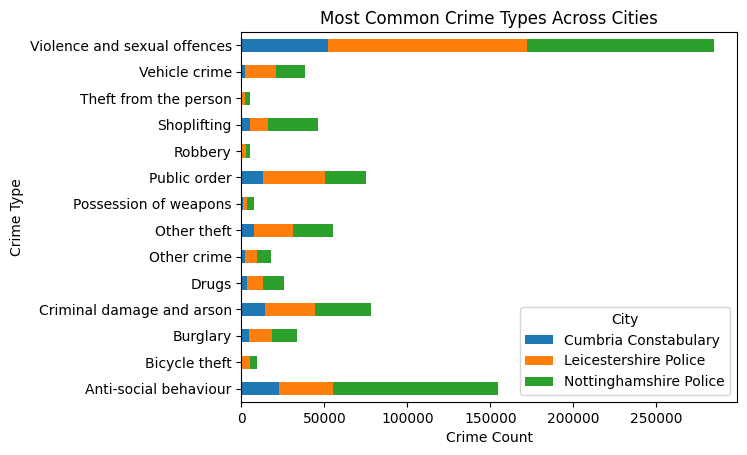

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the Spark DataFrame to a pandas DataFrame
most_common_crime_types_pd = most_common_crime_types.toPandas()

# Plot a horizontal stacked bar chart
plt.figure(figsize=(10, 6))
ax = most_common_crime_types_pd.pivot(index="Crime_Type", columns="Falls_within", values="crime_count").plot(kind="barh", stacked=True)
plt.xlabel("Crime Count")
plt.ylabel("Crime Type")
plt.title("Most Common Crime Types Across Cities")
plt.legend(title="City")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
crime_distribution_pd = crime_distribution_by_month.toPandas()

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Iterate over unique cities
for city in crime_distribution_pd['Falls_within'].unique():
    city_data = crime_distribution_pd[crime_distribution_pd['Falls_within'] == city]
    ax.plot(city_data['month'], city_data['crime_count'], label=city)

ax.set_xlabel('Month')
ax.set_ylabel('Crime Count')
ax.set_title('Crime Distribution by Month across Cities')
ax.legend()

plt.show()



In [30]:
from pyspark.sql.functions import count, desc
from pyspark.sql.window import Window

# Group by location and city, and count the number of crimes
crime_density_by_location = County_Crime.groupBy("Location", "Falls_within").agg(count("*").alias("crime_count"))
# Create a window specification partitioned by city
window_spec = Window.partitionBy("Falls_within")
# Calculate the crime density per location within each city
crime_density_by_location = crime_density_by_location.withColumn("crime_density", crime_density_by_location["crime_count"] 
                                                                 / count("Location").over(window_spec))
# Sort the result by crime density in descending order
crime_density_by_location = crime_density_by_location.orderBy(desc("crime_density"))
# Display the crime density by location across cities
crime_density_by_location.show()


+--------------------+--------------------+-----------+-------------------+
|            Location|        Falls_within|crime_count|      crime_density|
+--------------------+--------------------+-----------+-------------------+
|         On or near |Nottinghamshire P...|      17014| 1.3904870872834258|
|         On or near |Leicestershire Po...|      11636| 1.1536783660519532|
|On or near Superm...|Nottinghamshire P...|      11153| 0.9114906832298136|
|         On or near |Cumbria Constabulary|       5029| 0.8652787336545079|
|On or near Parkin...|Cumbria Constabulary|       4429| 0.7620440467997247|
|On or near Parkin...|Nottinghamshire P...|       8335| 0.6811866623079438|
|         No Location|Leicestershire Po...|       6207|   0.61540749553837|
|On or near Superm...|Leicestershire Po...|       6121| 0.6068808249058101|
|On or near Parkin...|Leicestershire Po...|       5322| 0.5276621058893516|
|On or near Shoppi...|Nottinghamshire P...|       6260| 0.5116050997057862|
|On or near 

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import accumulate

# Convert the DataFrame to Pandas for plotting
outcome_pd = outcome_of_crimereporting.toPandas()

# Plot the stacked graph
fig, ax = plt.subplots()

# Set the colors for the stacked bars
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

# Iterate over each city and plot the stacked bars
for i, row in outcome_pd.iterrows():
    city = row["Reported_by"]
    crime_outcomes = row[2:]  # Exclude the 'Reported_by' column

    # Remove rows with zero counts
    crime_outcomes = crime_outcomes[crime_outcomes != 0]

    # Calculate the cumulative sum of counts for stacked bars
    cum_sum = [0] + list(accumulate(crime_outcomes))

    # Plot the stacked bars
    for j, outcome in enumerate(crime_outcomes):
        ax.bar(city, outcome, bottom=cum_sum[j], color=colors[j])

# Set the labels and title
ax.set_xlabel("City")
ax.set_ylabel("Crime Count")
ax.set_title("Crime Outcomes by City")

# Show the legend
ax.legend(outcome_pd.columns[2:])

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


NameError: name 'outcome_of_crimereporting' is not defined